In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error






# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree


# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import os 
import sys


sys.path.append(os.path.abspath("../src"))   
import soporte_regresion as f

In [2]:
df_encoded=pd.read_csv("..\datos2\datos_nulos_encoded.csv", index_col=0).reset_index(drop=True)

In [3]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351586 entries, 0 to 351585
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                351586 non-null  float64
 1   vehicleType          351586 non-null  float64
 2   yearOfRegistration   351586 non-null  float64
 3   gearbox              351586 non-null  float64
 4   monthOfRegistration  351586 non-null  float64
 5   fuelType             351586 non-null  float64
 6   brand                351586 non-null  float64
 7   notRepairedDamage    351586 non-null  float64
 8   yearCreated          351586 non-null  float64
 9   monthCreated         351586 non-null  float64
 10  powerCV_est          351586 non-null  float64
 11  kilometer_est        351586 non-null  float64
 12  abtest_control       351586 non-null  float64
 13  abtest_test          351586 non-null  float64
dtypes: float64(14)
memory usage: 37.6 MB


In [4]:
df_encoded.duplicated().sum()

np.int64(20851)

Separamos en x e y

In [5]:
x= df_encoded.drop(columns="price")
y= df_encoded[["price"]]

Separamos en train y test y le hacemos aprender

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.7, random_state=42)
modelo_lineal= LinearRegression()
modelo_lineal.fit(x_train, y_train) 

LinearRegression()

Ahora hacemos la predicción

In [7]:
y_test_pred=modelo_lineal.predict(x_test)         #con esto predice un precio
y_train_pred= modelo_lineal.predict(x_train)

***K-Fold***

In [8]:
f.metricas(y_train, y_train_pred, y_test, y_test_pred)

,train,test
r2_score,6.042614e-01,6.082187e-01
MAE,2.546050e+03,2.537407e+03
MSE,1.244816e+07,1.233543e+07
RMSE,3.528195e+03,3.512183e+03


In [9]:
kf= KFold(n_splits=5,
          shuffle=True,
          random_state=42)

score_r2= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "r2")
np.mean(score_r2)

np.float64(0.6054156698414652)

In [10]:
score_mae= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_mean_absolute_error")
abs(np.mean(score_mae))

np.float64(2543.178883446344)

In [11]:
score_mse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_mean_squared_error")
abs(np.mean(score_mse))

np.float64(12415405.54939652)

In [12]:
score_rmse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_root_mean_squared_error")
abs(np.mean(score_rmse))

np.float64(3523.5270992945407)

In [13]:
kf= KFold(n_splits=200,
          shuffle=True,
          random_state=42)

score_r2= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "r2")
np.mean(score_r2)

np.float64(0.6047586655722009)

In [14]:
score_rmse= cross_val_score(modelo_lineal, x, y, cv=kf, scoring= "neg_root_mean_squared_error")
abs(np.mean(score_rmse))

np.float64(3522.279882042392)

Cuantas más iteraciones más probabilidades de que seleccione el mismo paquete sobre el que aprender con lo que hay más riesgo de over fitting (porque es seleccion aleatoria)

**Como seleccionar que variables independientes eliminar si sucede over fitting**

In [15]:
pd.options.display.float_format = "{:,.2f}".format  #para quitar la notación cientifica
df_coefs=pd.DataFrame(modelo_lineal.coef_, columns= x.columns).T
df_coefs.sort_values(by=0, key= abs, ascending=False)    #para que ordene según la importancia

,0
kilometer_est,"-2,276.07"
powerCV_est,"1,535.76"
abtest_control,9.09
abtest_test,-9.09
fuelType,0.65
yearOfRegistration,0.57
notRepairedDamage,0.49
monthCreated,0.45
brand,0.42
vehicleType,0.36


recursive_feature_elimination (PENDIENTE DE USO)

### Como me he dado cuenta de que no parece ser una relación lineal paso a decision tree

**DECISION TREE**  
Separa los datos en nodos y luego hace la media en el nodo final de la variable dependiente para los datos que se encuentran en ese nodo y cuando tenga que predecir, si el dato acaba en ese nodo, se le aplicará esa media como valor de su variable dependiente.  
   
***Para elegir el mejor árbol de decisión (conformado de unas variables independientes concretas)***   
Calcula la suma de los errores al cuadrado dividido entre n del nodo final de cada arbol y compara ese error y se queda con el que tenga el error mínimo
  
- Si hay mucha profundidad, los nodos finales van a ser tan específicos que se va a dar over fitting
  
***Como decirle que pare de dividir para evitar el Over Fitting***  
- max_depth (profundida máxima del árbol)
- min_sample_split (numero de datos minimo en el nodo (madre) para que se pueda dividir)  
- min_sample_leaf (numero de datos minimo que tienen que tener los nodos(hijos) en los que me divido) 
- max_leaf_nodes (numero maximo de nodos que quiero que tenga mi arbol)  
- max_features (numero máximo de variables independientes que queremos)

Pruebo primero a ver cómo me lo hace 

In [16]:
modelo_arbol_vacio= DecisionTreeRegressor()         
modelo_arbol_vacio.fit(x_train, y_train)
y_pred_test_arb_vacio= modelo_arbol_vacio.predict(x_test)
y_pred_train_arb_vacio= modelo_arbol_vacio.predict(x_train)
df_metricas_arbol_vacio= f.metricas(y_train, y_pred_train_arb_vacio, y_test, y_pred_test_arb_vacio)
df_metricas_arbol_vacio

,train,test
r2_score,0.97,0.72
MAE,356.72,"1,717.15"
MSE,"865,295.07","8,775,095.62"
RMSE,930.21,"2,962.28"


Dejándole a él sólo me da que se produce overfitting

In [17]:
# plot_tree(decision_tree=modelo_arbol, feature_names=x.columns, filled=True)

In [18]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 50, 100, 200],
    'max_leaf_nodes': [4, 6, 8, 10, 20, 30]
}

grid_search_arbol=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol, cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_leaf_nodes': [4, 6, 8, 10, 20, 30],
                         'min_samples_leaf': [10, 50, 100, 200],
                         'min_samples_split': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error')

In [19]:
modelo_final_arbol=grid_search_arbol.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=30, min_samples_leaf=10,
                      min_samples_split=10)

In [20]:
y_pred_test_arb= modelo_final_arbol.predict(x_test)
y_pred_train_arb= modelo_final_arbol.predict(x_train)
df_metricas_arbol= f.metricas(y_train, y_pred_train_arb, y_test, y_pred_test_arb)
df_metricas_arbol=df_metricas_arbol.T
df_metricas_arbol.reset_index(inplace=True)
df_metricas_arbol



,index,r2_score,MAE,MSE,RMSE
0,train,0.64,"2,281.91","11,424,185.68","3,379.97"
1,test,0.64,"2,274.96","11,339,304.16","3,367.39"


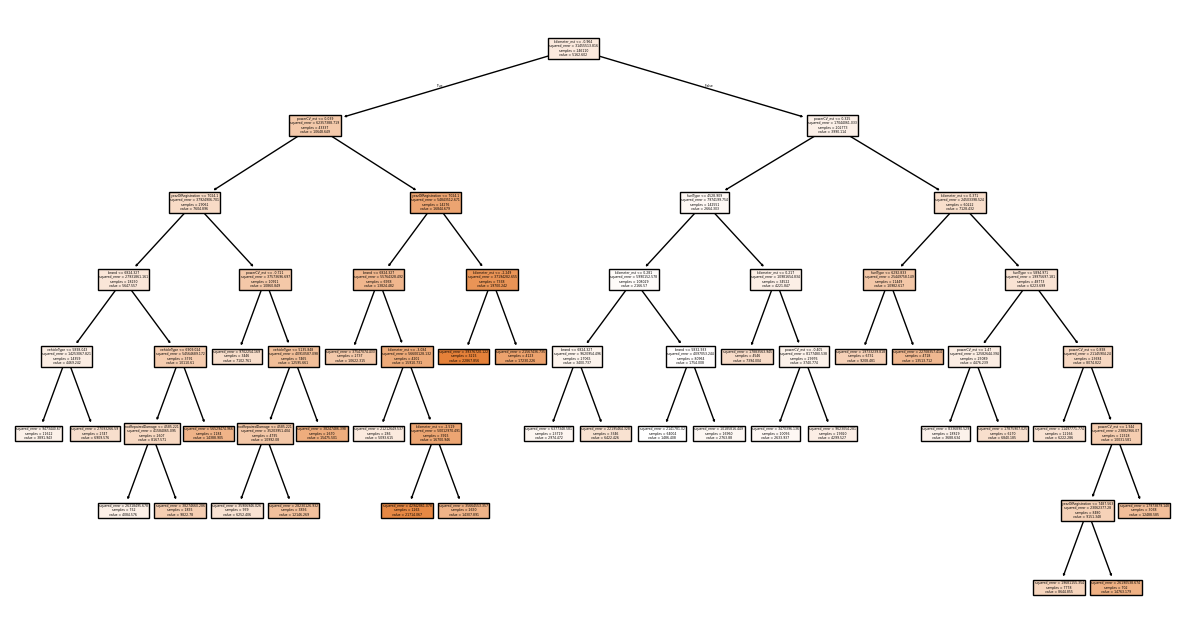

In [21]:
plt.figure(figsize=(15,8))
plot_tree(decision_tree=modelo_final_arbol, feature_names=x.columns, filled=True);

AHORA QUE SABEMOS QUE LA MEJOR DEPTH ES 10 ESTARÍA BIEN COMPARAR LA 10,11 Y 12 PARA VER SI SIGUE SIENDO LA MEJOR EL 10

### Vamos a graficarlo porque así se entienden mejor

In [22]:
df_resultados_arbol=pd.DataFrame(grid_search_arbol.cv_results_)

In [23]:
df_resultados_arbol.sort_values(by= "rank_test_score", ascending=True).head(2)    #aquí podemos ver cual nos ha dado como mejor modelo (el 1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
272,0.89,0.02,0.01,0.00,7,30,10,10,"{'max_depth': 7, 'max_leaf_nodes': 30, 'min_sa...","-11,430,936.52","-11,287,526.48","-11,502,312.15","-11,203,638.11","-11,780,568.75","-11,440,996.40","199,530.54",1
273,0.90,0.02,0.02,0.00,7,30,10,50,"{'max_depth': 7, 'max_leaf_nodes': 30, 'min_sa...","-11,430,936.52","-11,287,526.48","-11,502,312.15","-11,203,638.11","-11,780,568.75","-11,440,996.40","199,530.54",1


In [24]:
df_resultados_arbol.shape   #no da el número de modelos que ha generado el árbol 

(384, 17)

In [25]:
df_resultados_arbol_filtrado=df_resultados_arbol.filter(like= "param").drop(columns= "params")
df_resultados_arbol_filtrado["MSE"]= df_resultados_arbol["mean_test_score"]
df_resultados_arbol_filtrado.head()


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,3,4,10,10,"-18,279,294.51"
1,3,4,10,50,"-18,279,294.51"
2,3,4,10,100,"-18,279,294.51"
3,3,4,10,200,"-18,279,294.51"
4,3,4,50,10,"-18,279,294.51"


In [26]:
df_rmse_profun= np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs()).reset_index()
df_rmse_profun.head()

,param_max_depth,MSE
0,3,"4,038.91"
1,5,"3,861.92"
2,7,"3,853.50"
3,10,"3,853.56"


## Estaría bien probarlo con el 11 y 12 para comprobar si consigo que siga bajando

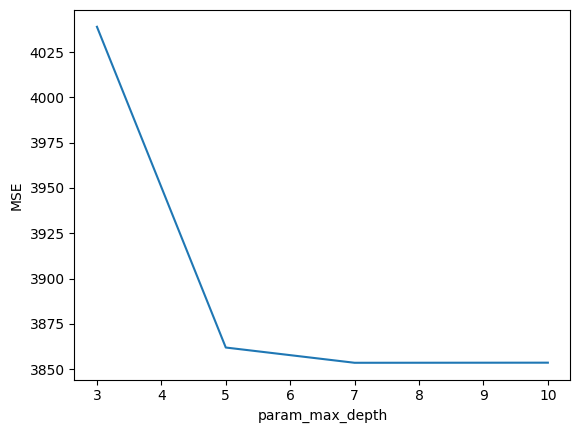

In [27]:
sns.lineplot(x= "param_max_depth", y = "MSE", data= df_rmse_profun);

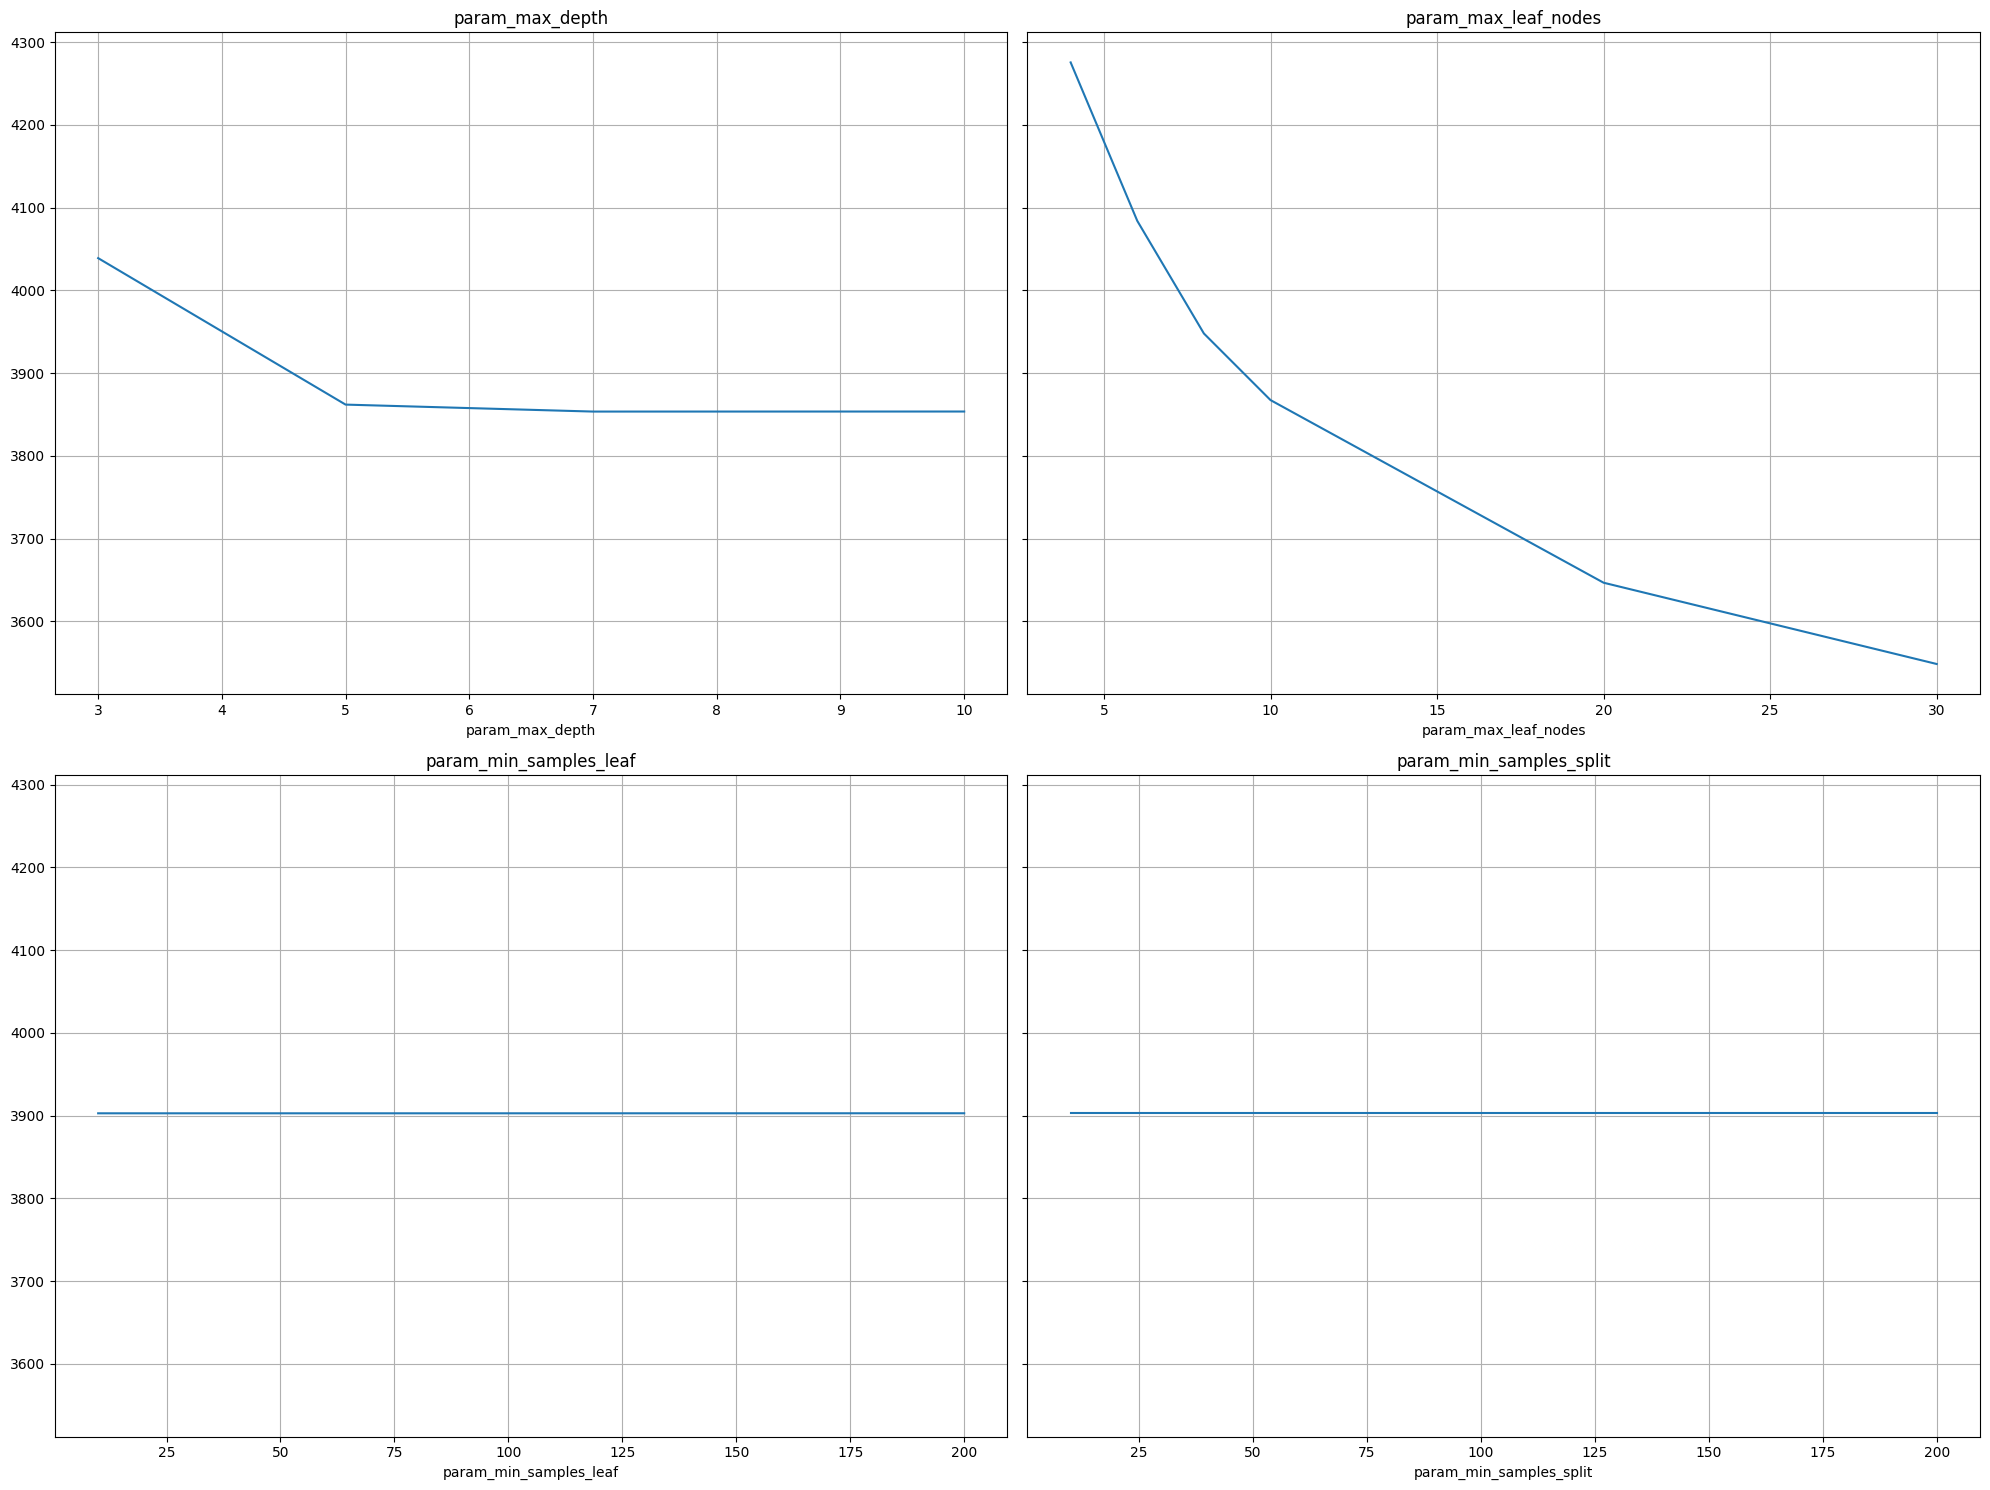

In [28]:

df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs())
df_rmse_prof = pd.DataFrame(df_rmse_prof).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    df_rmse_col = np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())
    sns.lineplot(x=df_rmse_col.index, y=df_rmse_col.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)
plt.tight_layout()
plt.show() 

In [29]:
pd.DataFrame(modelo_final_arbol.feature_importances_, columns= ["Importancia"], index= x.columns).sort_values(by = "Importancia", ascending=False)

,Importancia
kilometer_est,0.41
powerCV_est,0.39
yearOfRegistration,0.07
fuelType,0.06
brand,0.04
vehicleType,0.02
notRepairedDamage,0.01
monthOfRegistration,0.00
gearbox,0.00
monthCreated,0.00


## Lo pruebo cambiando parametros

In [30]:
# Parámetros a evaluar
params_arbol_prueba = {
    'max_depth': [7,8, 60, 100, 200],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 50, 100, 200],
    'max_leaf_nodes': [4, 6, 8, 10, 20, 80]
}

grid_search_arbol_prueba=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol_prueba , cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol_prueba.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 60, 100, 200],
                         'max_leaf_nodes': [4, 6, 8, 10, 20, 80],
                         'min_samples_leaf': [10, 50, 100, 200],
                         'min_samples_split': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error')

In [31]:
modelo_final_arbol_prueba=grid_search_arbol_prueba.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol_prueba

DecisionTreeRegressor(max_depth=60, max_leaf_nodes=80, min_samples_leaf=10,
                      min_samples_split=10)

In [32]:
y_pred_test_arb_prueba= modelo_final_arbol_prueba.predict(x_test)
y_pred_train_arb_prueba= modelo_final_arbol_prueba.predict(x_train)
df_metricas_arbol_prueba= f.metricas(y_train, y_pred_train_arb_prueba, y_test, y_pred_test_arb_prueba)

df_metricas_arbol_prueba=df_metricas_arbol_prueba.T
df_metricas_arbol_prueba.reset_index(inplace=True)
df_metricas_arbol_prueba

,index,r2_score,MAE,MSE,RMSE
0,train,0.70,"2,072.74","9,473,969.97","3,077.98"
1,test,0.70,"2,068.75","9,452,706.90","3,074.53"


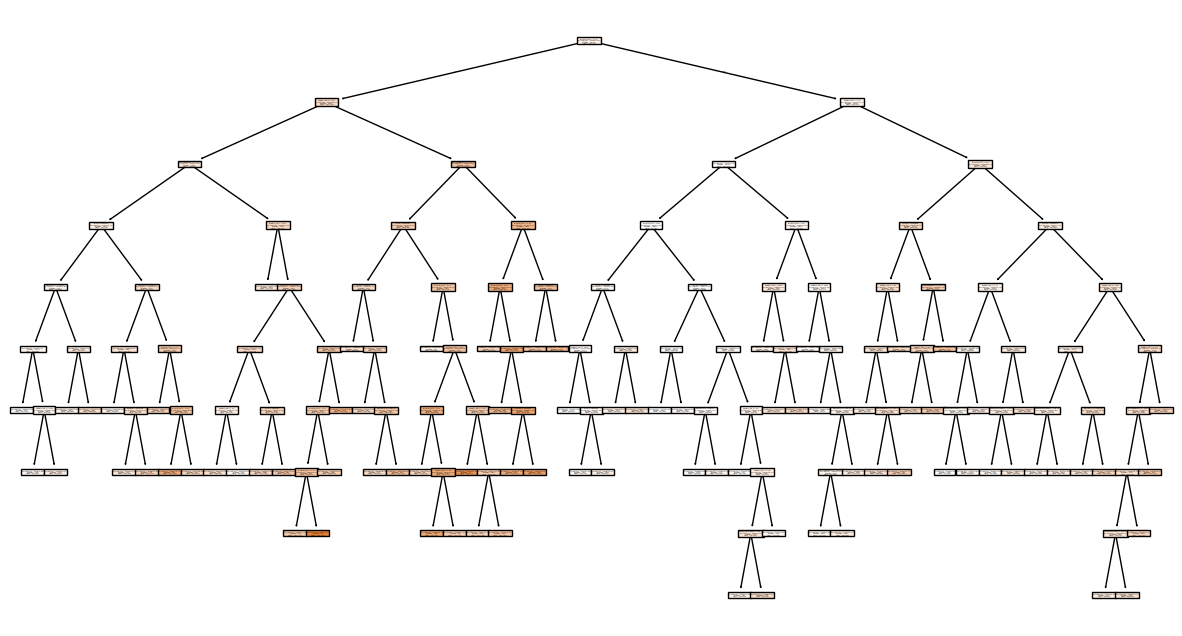

In [33]:
plt.figure(figsize=(15,8))
plot_tree(decision_tree=modelo_final_arbol_prueba, feature_names=x.columns, filled=True);

AHORA QUE SABEMOS QUE LA MEJOR DEPTH ES 60 ESTARÍA BIEN COMPARAR LA 10,11 Y 12 PARA VER SI SIGUE SIENDO LA MEJOR EL 10

### Vamos a graficarlo porque así se entienden mejor

In [34]:
df_resultados_arbol_prueba=pd.DataFrame(grid_search_arbol_prueba.cv_results_)

In [35]:
df_resultados_arbol_prueba.sort_values(by= "rank_test_score", ascending=True).head(2)    #aquí podemos ver cual nos ha dado como mejor modelo (el 1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
368,1.24,0.19,0.02,0.00,100,80,10,10,"{'max_depth': 100, 'max_leaf_nodes': 80, 'min_...","-9,496,629.44","-9,633,490.16","-9,569,004.43","-9,381,974.56","-9,769,114.81","-9,570,042.68","129,934.98",1
369,1.24,0.19,0.02,0.01,100,80,10,50,"{'max_depth': 100, 'max_leaf_nodes': 80, 'min_...","-9,496,629.44","-9,633,490.16","-9,569,004.43","-9,381,974.56","-9,769,114.81","-9,570,042.68","129,934.98",1


In [36]:
df_resultados_arbol_prueba.shape   #no da el número de modelos que ha generado el árbol 

(480, 17)

In [37]:
df_resultados_arbol_filtrado_prueba=df_resultados_arbol_prueba.filter(like= "param").drop(columns= "params")
df_resultados_arbol_filtrado_prueba["MSE"]= df_resultados_arbol_prueba["mean_test_score"]
df_resultados_arbol_filtrado_prueba.head()


,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,7,4,10,10,"-18,279,294.51"
1,7,4,10,50,"-18,279,294.51"
2,7,4,10,100,"-18,279,294.51"
3,7,4,10,200,"-18,279,294.51"
4,7,4,50,10,"-18,279,294.51"


In [38]:
df_rmse_profun_prueba= np.sqrt(df_resultados_arbol_filtrado_prueba.groupby("param_max_depth")["MSE"].mean().abs()).reset_index()
df_rmse_profun_prueba.head()

,param_max_depth,MSE
0,7,"3,817.44"
1,8,"3,814.56"
2,60,"3,814.11"
3,100,"3,814.11"
4,200,"3,814.11"


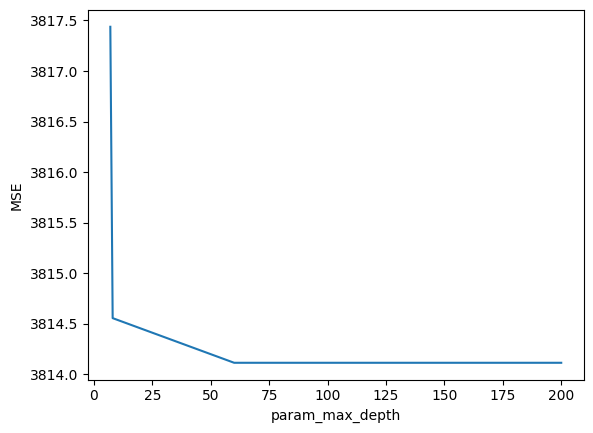

In [39]:
sns.lineplot(x= "param_max_depth", y = "MSE", data= df_rmse_profun_prueba);

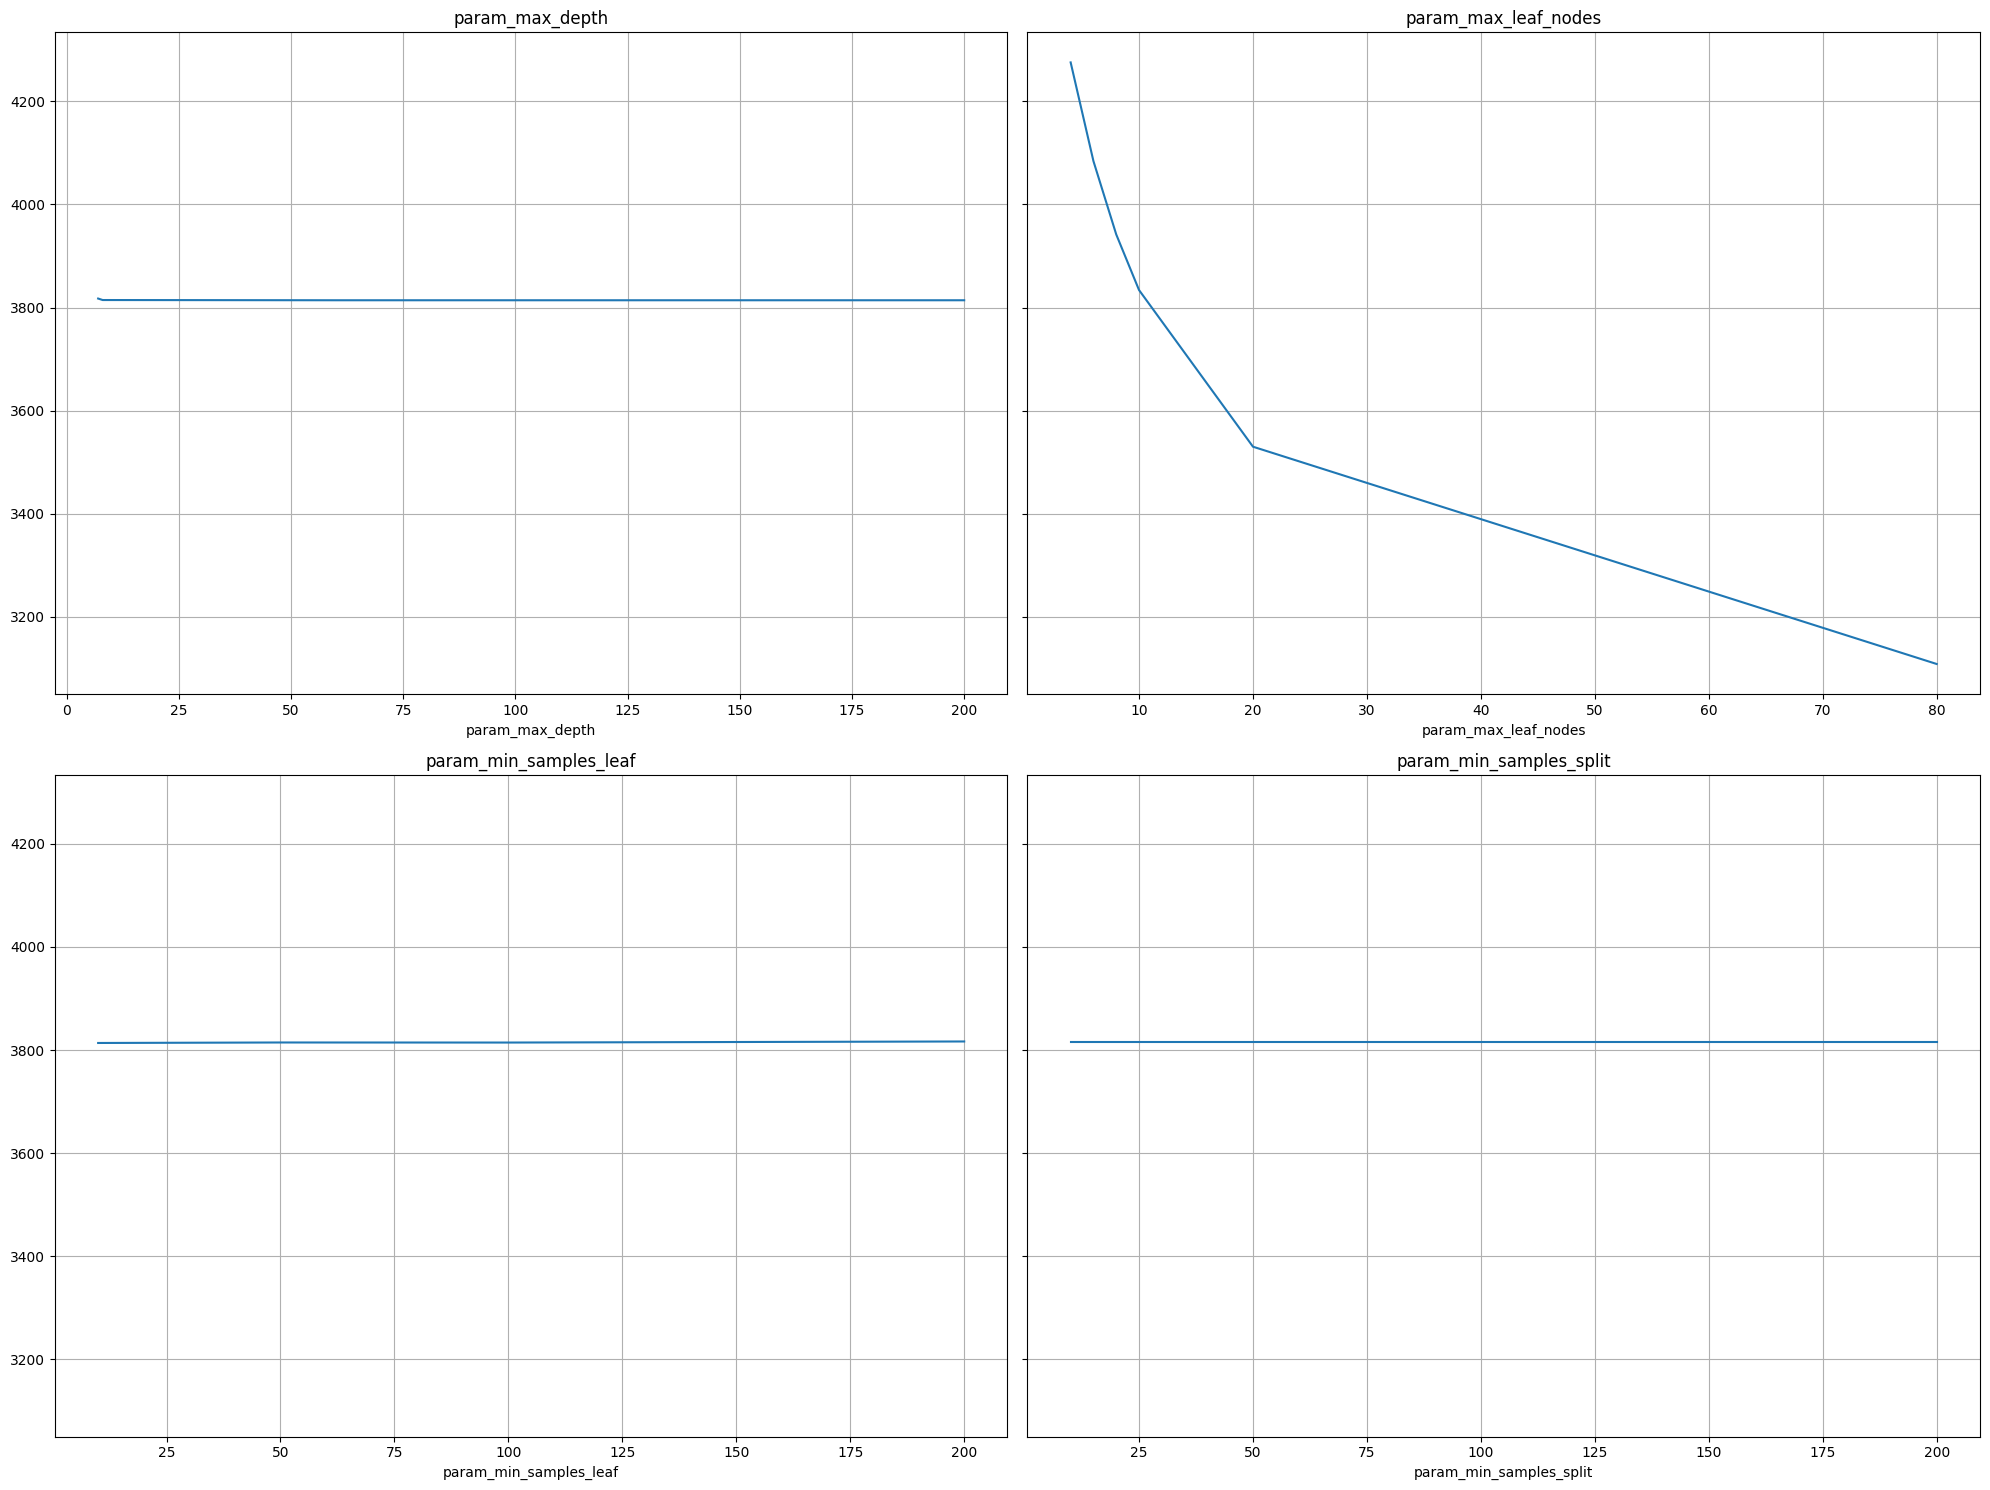

In [40]:

df_rmse_profun_prueba = np.sqrt(df_resultados_arbol_filtrado_prueba.groupby("param_max_depth")["MSE"].mean().abs())
df_rmse_profun_prueba = pd.DataFrame(df_rmse_profun_prueba).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado_prueba.columns[:-1]):
    df_rmse_col_prueba = np.sqrt(df_resultados_arbol_filtrado_prueba.groupby(column)["MSE"].mean().abs())
    sns.lineplot(x=df_rmse_col_prueba.index, y=df_rmse_col_prueba.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)
plt.tight_layout()
plt.show() 

In [41]:
pd.DataFrame(modelo_final_arbol_prueba.feature_importances_, columns= ["Importancia"], index= x.columns).sort_values(by = "Importancia", ascending=False).head()

,Importancia
kilometer_est,0.39
powerCV_est,0.37
yearOfRegistration,0.07
fuelType,0.06
brand,0.05


De momento parece que mi segunda opción de parámetros me da los mejores resultados.

In [42]:
# Parámetros a evaluar
params_arbolu = {
    'max_depth': [7, 8, 200, 2000],
    'min_samples_split': [10, 50, 500, 2000],
    'min_samples_leaf': [10, 50, 500, 2000],
    'max_leaf_nodes': [4, 6, 8, 10, 100, 2000]
}

grid_search_arbolu=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbolu, cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbolu.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 200, 2000],
                         'max_leaf_nodes': [4, 6, 8, 10, 100, 2000],
                         'min_samples_leaf': [10, 50, 500, 2000],
                         'min_samples_split': [10, 50, 500, 2000]},
             scoring='neg_mean_squared_error')

In [43]:
modelo_final_arbolu=grid_search_arbolu.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbolu

DecisionTreeRegressor(max_depth=200, max_leaf_nodes=2000, min_samples_leaf=10,
                      min_samples_split=10)

In [44]:
y_pred_test_arbu= modelo_final_arbolu.predict(x_test)
y_pred_train_arbu= modelo_final_arbolu.predict(x_train)
df_metricas_arbolu= f.metricas(y_train, y_pred_train_arbu, y_test, y_pred_test_arbu)
df_metricas_arbolu=df_metricas_arbolu.T
df_metricas_arbolu.reset_index(inplace=True)
df_metricas_arbolu

,index,r2_score,MAE,MSE,RMSE
0,train,0.82,"1,540.81","5,558,844.67","2,357.72"
1,test,0.80,"1,618.09","6,414,415.48","2,532.67"


In [45]:
dicc={0: "modelo1",
      1: "modelo1",
      2: "modelo2",
      3: "modelo2",
      4: "modelo3",
      5: "modelo3"}

In [46]:
df_final=pd.DataFrame()
df_final=pd.concat([df_final,df_metricas_arbolu, df_metricas_arbol_prueba,df_metricas_arbol], axis=0, ignore_index=True)
df_final.reset_index(inplace=True)
df_final["level_0"]=df_final["level_0"].map(dicc)
df_final

,level_0,index,r2_score,MAE,MSE,RMSE
0,modelo1,train,0.82,"1,540.81","5,558,844.67","2,357.72"
1,modelo1,test,0.80,"1,618.09","6,414,415.48","2,532.67"
2,modelo2,train,0.70,"2,072.74","9,473,969.97","3,077.98"
3,modelo2,test,0.70,"2,068.75","9,452,706.90","3,074.53"
4,modelo3,train,0.64,"2,281.91","11,424,185.68","3,379.97"
5,modelo3,test,0.64,"2,274.96","11,339,304.16","3,367.39"


## Finalmente me quedo con el modelo 1 correspondiente al 2000

In [47]:
df_metricas_arbolu.drop(columns= "index", inplace=True)

In [48]:
df_metricas_arbolua=df_metricas_arbolu.T
df_metricas_arbolua.columns= ["train", "test"]
df_metricas_arbolua.reset_index(inplace=True)
df_metricas_arbolua

,index,train,test
0,r2_score,0.82,0.80
1,MAE,"1,540.81","1,618.09"
2,MSE,"5,558,844.67","6,414,415.48"
3,RMSE,"2,357.72","2,532.67"


Vamos a intentar visualizar las cositas

In [49]:
predytest=pd.DataFrame(y_pred_test_arbu, columns=["y_pred_test_arbu"])

In [50]:
predytrain=pd.DataFrame(y_pred_train_arbu, columns=["y_pred_train_arbu"])

In [51]:
df_fin=pd.DataFrame()
df_fin=pd.concat([df_fin, predytest, predytrain, y], ignore_index=True, axis=1)

In [52]:
df_fin.columns= ["test_prediccion", "train_prediccion", "precio_original"]

In [53]:
df_fin.reset_index(inplace=True)

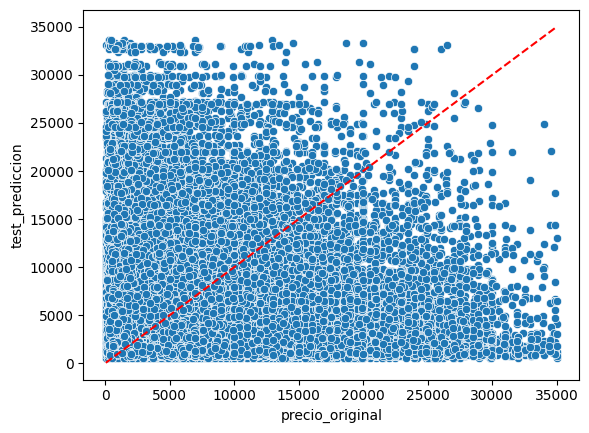

In [54]:
sns.scatterplot(x="precio_original", y="test_prediccion", data= df_fin)
plt.plot([df_fin["precio_original"].min(), df_fin["precio_original"].max()],
         [df_fin["precio_original"].min(), df_fin["precio_original"].max()],
         color='red', linestyle='--', label='x = y')

In [55]:
df_fino=df_fin[df_fin["precio_original"] <200000]

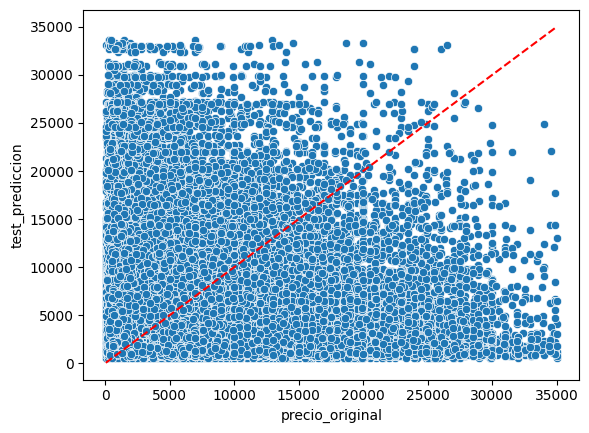

In [56]:
sns.scatterplot(x="precio_original", y="test_prediccion", data= df_fino)
plt.plot([df_fino["precio_original"].min(), df_fino["precio_original"].max()],
         [df_fino["precio_original"].min(), df_fino["precio_original"].max()],
         color='red', linestyle='--', label='x = y')

***CONCLUSIONES DE ESTE MODELO 1 PARA INTENTAR MEJORAR***  
  
- Este modelo 1 me predice mal los precios 0-30000 y 40000-5000000 (me predice los coches caros como baratos y viceversa)  
- Además más allá de 200000 no me predice nada.